In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle
import math
from itertools import permutations

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, sizes=100,
             legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata[xdata > 0.])#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata[ydata > 0.])#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
    return 

# Planet data in usable format
## each planet object includes some combination of: [Teff, logg, [Fe/H], Rp/R*, P]

In [11]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    lastEpochCost = float(lastEpoch[2].split(" ")[2])
    return lastEpochCost

In [9]:
experimentName = "realKOIs_allFeatures"
experimentClass = "allFeatures_2classes"
n_planet_features = 2
n_stellar_features = 3
n_features = n_planet_features + n_stellar_features



optimalLosses = []
nDisagrees = []

# set up results plot 
labels = [r'$R_p/R_*$',r'P [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$',r'[Fe/H]',]
scaledLimits = [(-0.5,1.),(-0.5,1.),(-3.5,6.),(-5.5,3.5),(-3,2.6)]
classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B','#2E8B57','#EE4266','#540D6E','#064F40','#F54D27']
#cl = ['#7A1809','#36747D','#F6AA1C']

# plot outcomes from many experiments
for ii in range(31,100):
    # get data
    with open("realPlanets/{0}.txt".format(experimentName), "rb") as picklefile:
        systems = pickle.load(picklefile)

    data = np.zeros((1,n_features))

    for i in range(len(systems)):
        sys = systems[i]
        for j in range(len(sys)):
            data = np.vstack((data,np.array(sys[j])))
            
    results = np.load("./realPlanets/{0}/{1}_classprobs_softmax_{2}.npy".format(experimentClass,experimentName,ii))
    results_fromContext = np.load("./realPlanets/{0}/{1}_classprobs_fromcontext_logsoftmax_{2}.npy".format(experimentClass,experimentName,ii))
    print(np.median(results))
    idxs = np.load("./realPlanets/{0}/{1}_idxs_{2}.npy".format(experimentClass,experimentName,ii))
    data = data[1:][idxs]
    
    losses = np.load("./realPlanets/{0}/{1}_losses_{2}.npy".format(experimentClass,experimentName,ii))

    optimalLoss = getLossFromLogfile("./realPlanets/{0}/example-sim-model_{1}_seed={2}.log".format(experimentClass,experimentName,ii))
    optimalLosses.append(optimalLoss)
    #print(optimalLoss)
    
    #bits = -1*optimalLoss*math.log(math.e,2)
    #print(bits)
    #plt.plot(losses[:,0],losses[:,1],'k.')
    #plt.axhline(y=optimalLoss,color='r',ls="--",lw=1)
    #plt.show()


    #plt.hist(results)
    #plt.show()

    bestClass = np.argmax(results,axis=1)
    bestClass_fromContext = np.argmax(results_fromContext,axis=1)

    #fig = plt.figure(figsize=(4,4))
    #plt.scatter(bestClass+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass)),
    #            bestClass_fromContext+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass_fromContext)),
    #            color='k',marker='.',alpha=0.1)
    #plt.xlabel("best class, from target")
    #plt.ylabel("best class, from context")
    #plt.show()

    nDisagree = len(np.arange(len(bestClass))[bestClass != bestClass_fromContext])
    nDisagrees.append(nDisagree)
    
    # TRUTHS and RESULTS
    arrays_ = [bestClass,bestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]

    for h in range(0,2):
        class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

        fig = plt.figure(figsize=(7*n_features,7*n_features))
        gs = gridspec.GridSpec(n_features, n_features)

        for i in range(n_features):
            for j in range(n_features):
                if i>j:
                    ax = plt.subplot(gs[i,j])
                    makePlot(ax,
                            xdata=data[:,j],#+arrays_[h]/3.,
                            ydata=data[:,i],
                            colours=class_colours,
                            xlim=scaledLimits[j],
                            ylim=scaledLimits[i],
                            legendTitle="{0}\nclass\nindex".format(titles_[h]),
                            legendEntries=np.array(class_legendEntries).astype(int),
                            legendColours=class_legendColours,
                            #xscale="log",
                            #yscale="log",
                            xlabel=labels[j],
                            ylabel=labels[i],
                            alpha=0.25)

                if i==j:
                    ax = plt.subplot(gs[i,j])
                    toHist = []
                    nmax = 0
                    for k in np.unique(arrays_[h]).astype(int):
                        #toHist.append(data[:,i][arrays_[h]==k])
                        try:
                            n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                            if np.max(n)>nmax:
                                nmax=np.max(n)
                        except IndexError:
                            n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                            if np.max(n)>nmax:
                                nmax=np.max(n)

                    #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                    #nmax = np.max(n)
                    ax.set_xlabel(labels[i],fontsize=24)
                    ax.tick_params(labelsize=18)
                    ax.set_xlim(scaledLimits[i])
                    ax.set_ylim(0,nmax*1.1)


        plt.subplots_adjust(wspace=0.2,hspace=0.2)
        #plt.show()
        print(ii)
        plt.savefig("./realPlanets/{0}/{1}_{2}_{3}.png".format(experimentClass,experimentName,plotTitles_[h],ii),fmt="png")
        plt.close()

0.5
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=31.log
31
31
0.4999999850988388
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=32.log
32
32
0.5
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=33.log
33
33
0.4999999850988388
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=34.log
34
34
0.5
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=35.log
35
35
0.5
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=36.log
36
36
0.5
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=37.log
37
37
0.4999999701976776
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=38.log
38
38
0.5
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeatures_seed=39.log
39
39
0.4999999701976776
./realPlanets/allFeatures_2classes/example-sim-model_realKOIs_allFeature

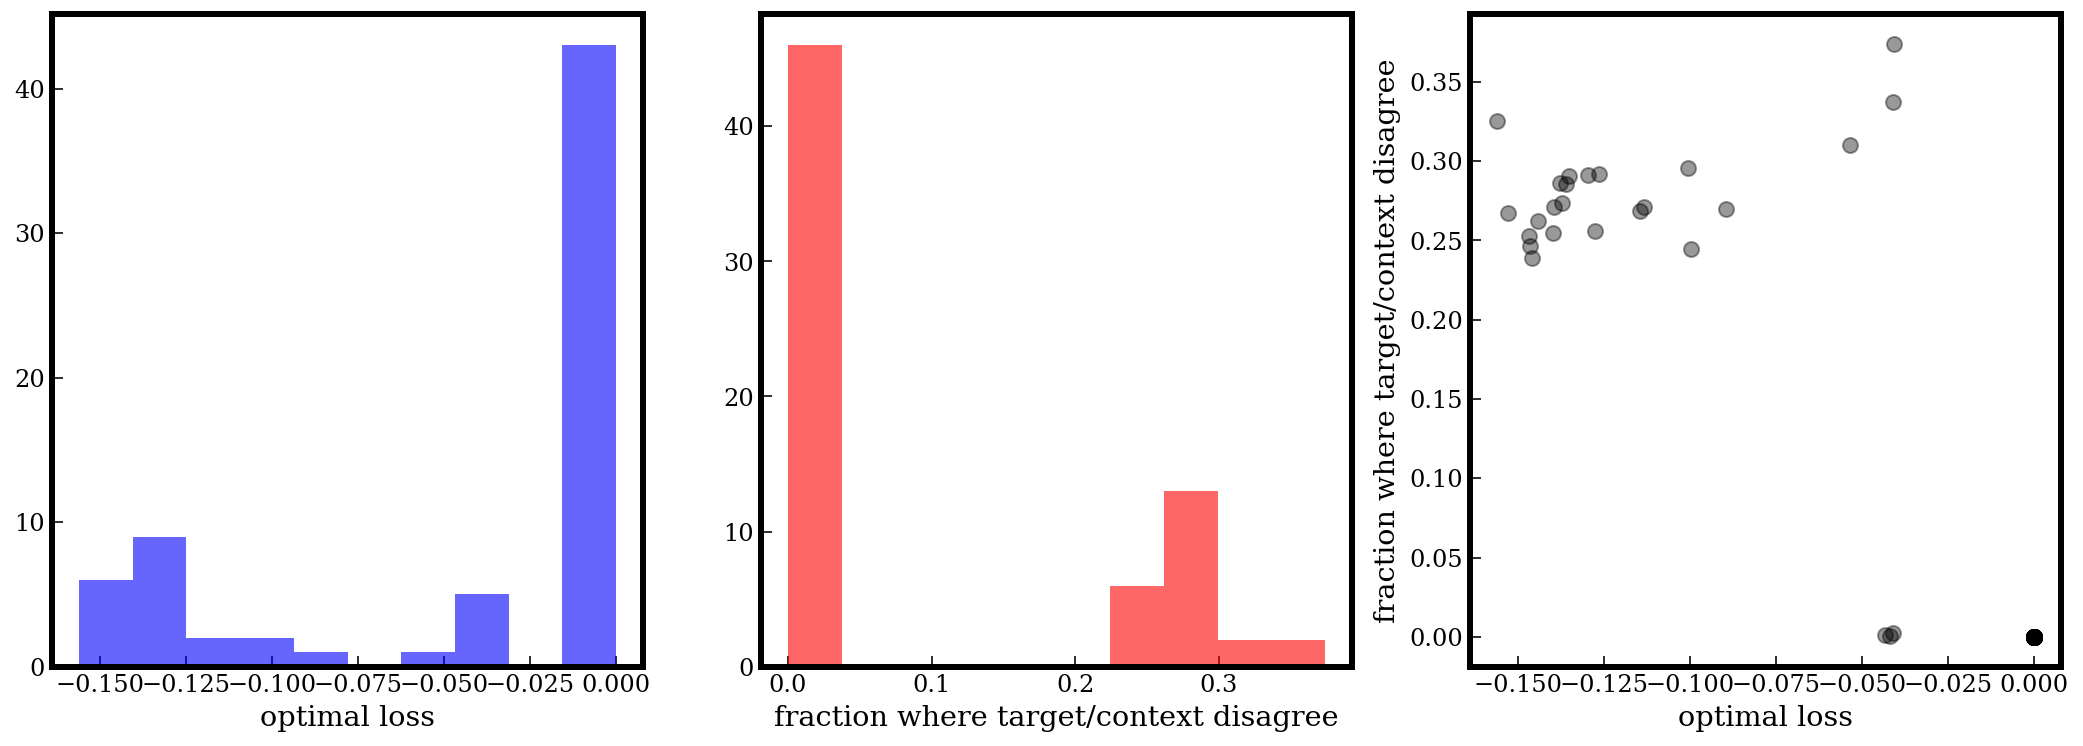

In [10]:
optimalLosses = np.array(optimalLosses)
nDisagrees = np.array(nDisagrees)
fracDisagrees = nDisagrees/len(data)

fig, axes, = plt.subplots(1,3,figsize=(18,6))
axes[0].hist(optimalLosses,color='b',alpha=0.6)
axes[0].set_xlabel("optimal loss")

axes[1].hist(fracDisagrees,color='r',alpha=0.6)
axes[1].set_xlabel("fraction where target/context disagree")

axes[2].plot(optimalLosses,fracDisagrees,'k.',ms=15,alpha=0.4)
axes[2].set_xlabel("optimal loss")
axes[2].set_ylabel("fraction where target/context disagree")

plt.savefig("nClasses=2.png",fmt="png")

In [64]:
nClasses = np.array((2,3,4,5))
bestCost = np.array((-0.159780619010,
                     -0.205503599744,
                     -0.175148372079,
                     -0.179275336400))
fracDisagree = np.array((1112,1323,1799,1683))/len(data)

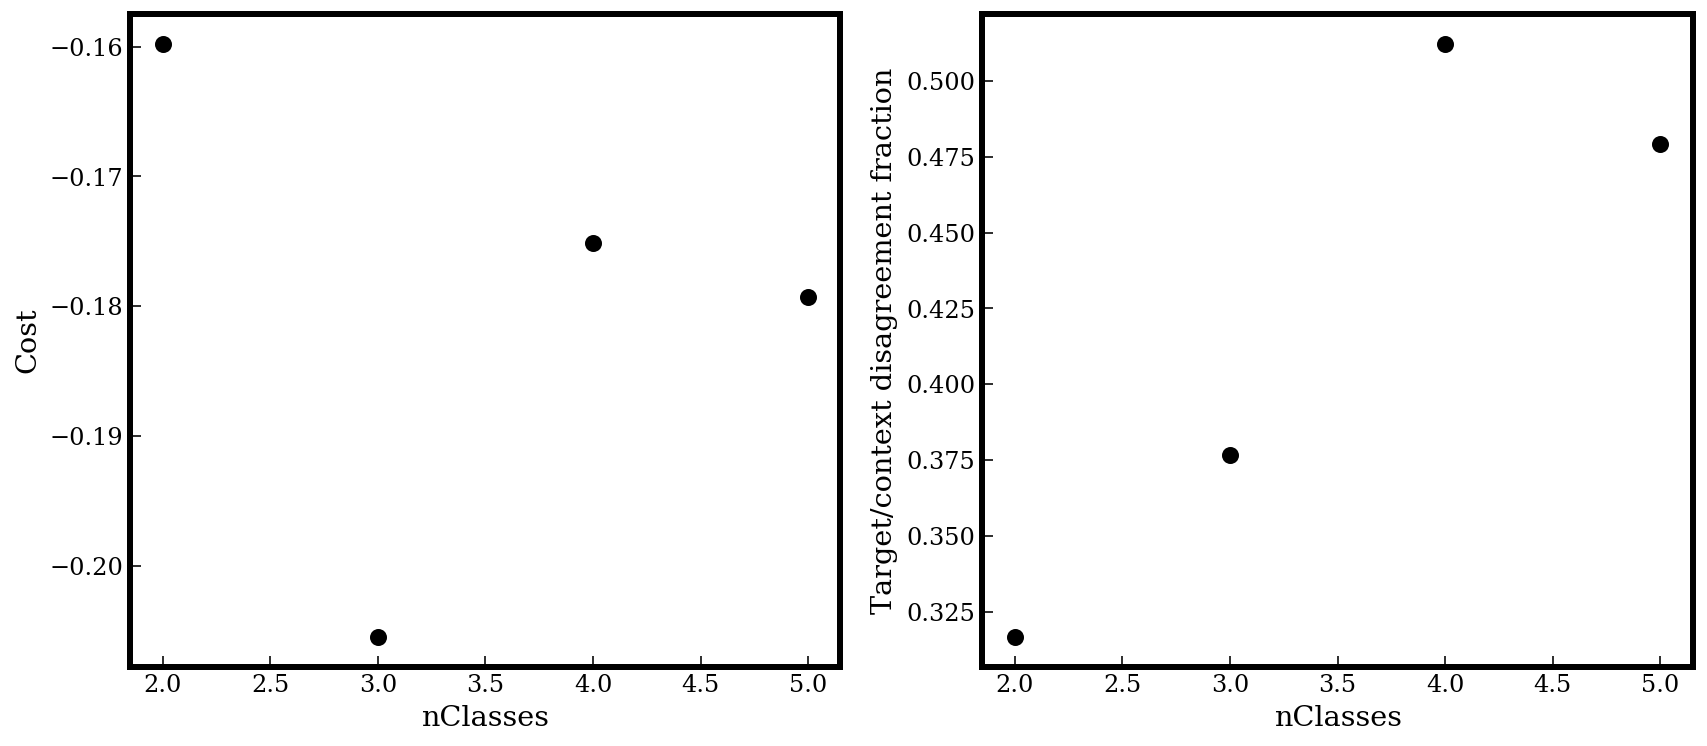

In [81]:
fig, axes, = plt.subplots(1,2,figsize=(14,6))
axes[0].plot(nClasses,bestCost,color='k',marker='.',ms=15,ls='None')
axes[0].set_xlabel("nClasses")
axes[0].set_ylabel("Cost")
axes[1].plot(nClasses,fracDisagree,color='k',marker='.',ms=15,ls='None')
axes[1].set_xlabel("nClasses")
axes[1].set_ylabel("Target/context disagreement fraction")
#plt.show()
plt.savefig("nClasses.png",fmt="png")